# Let's do Cartpole gym:)
https://stackoverflow.com/questions/50107530/how-to-render-openai-gym-in-google-colab

# Prerequites
It is needed for displaying the openAI in google colab

In [0]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install pyglet==v1.3.2

# Import Packages/Basic settings for Cartpole

In [0]:
# Basic packages
import gym
from gym import wrappers
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import math
import random
import matplotlib
from PIL import Image
# Keras packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
# Display packages
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import matplotlib.animation
from IPython.display import HTML
# Driver Package
import os
from google.colab import drive

In [0]:
drive.mount('/content/gdrive', force_remount=True)
!pwd
os.chdir('gdrive/Shared drives/Reinforcement Learning/Cartpole')
!pwd
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/Shared drives/Reinforcement Learning/Cartpole
 Cartpole_keras.ipynb
 Cartpole_Moving_Average_Reward_b128.PNG
 Cartpole_Moving_Average_Reward_b16.PNG
 Cartpole_Moving_Average_Reward_b32.PNG
 Cartpole_Moving_Average_Reward_b64_.PNG
'Cartpole_Moving_Average_Reward(Episode_403).PNG'
 Cartpole_NEW.ipynb
 Cartpole_pytorch_b128.ipynb
 Cartpole_pytorch_b16.ipynb
 Cartpole_pytorch_b32.ipynb
 Cartpole_pytorch_b64.ipynb
 Cartpole_pytorch_Differe

In [0]:
# Display setting
display = Display(visible=0, size=(400, 300))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1005'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1005'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
env = gym.make('CartPole-v0').unwrapped

## Replay Memory

We’ll be using experience replay memory for training our DQN. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

For this, we’re going to need two classses:

- Transition - a named tuple representing a single transition in our environment. It essentially maps (state, action) pairs to their (next_state, reward) result, with the state being the screen difference image as described later on. <br>
- ReplayMemory - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a .sample() method for selecting a random batch of transitions for training.

In [0]:
class ReplayMemory():
    def __init__(self, max_size):
        self.max_size = max_size
        self.transitions = deque()
    def add(self, state, action, reward, state2):
        if len(self.transitions) > self.max_size:
            self.transitions.popleft()
        self.transitions.append((state, action, reward, state2))
    def sample(self, count):
        return random.sample(self.transitions, count)
    def size(self):
        return len(self.transitions)

## DQN algorithm

Our environment is deterministic, so all equations presented here are also formulated deterministically for the sake of simplicity. In the reinforcement learning literature, they would also contain expectations over stochastic transitions in the environment.

In [0]:
def DQN():
    model = Sequential()
    model.add(Dense(16, input_shape=(4, ), activation='relu'))
    model.add(Dense(16, input_shape=(4,), activation='relu'))
    model.add(Dense(2, activation='linear'))
    model.compile(optimizer=Adam(lr=LR),loss='mse',metrics=[],)
    return model

# Hyperparamter Tuning
We try to change the parameter to optimize our agent and the evaulation study can be found below.

In [0]:
LR = 0.001 # optimizer learning rate
gamma = 0.99 # discount factor
num_episodes = 220 # number of episodes
target_update = 100
batch_size = 32 # Q-learning batch size
epsilon_decay = 0.99 # e-greedy decay value
epsilon_start = 1 # e-greedy start value
epi_time=[] # Rewards

# Display our model
Let's get screen size and initialize layers based on shape from OpenAI gym. 

In [0]:
# init_screen = display()
# _, _, screen_height, screen_width = init_screen.shape

# Run our model
Let's run for 220 episodes (took less than 1 hour in  Google Colab) and get some results!

In [0]:
#######################################################
def get_q(model, state):                              #
    obs = np.reshape(state, [-1, 4])                  #
    return model.predict(obs)                         #
#######################################################
def train(model, states, targets):                    #
    obs = np.reshape(states, [-1, 4])                 #
    targets = np.reshape(targets, [-1, 2])            # 
    model.fit(obs, targets, epochs=1, verbose=0)      #
#######################################################
def predict(model, state):                            #
    obs = np.reshape(state, [-1, 4])                  #
    return model.predict(obs)                         #
##########################################################################
def q_function(action_model, target_model, sample_transitions):          #
    random.shuffle(sample_transitions)                                   #
    batch_states = []                                                    #
    batch_targets = []                                                   #
    for sample_transition in sample_transitions:                         #
        old_state, action, reward, state = sample_transition             #
        targets = np.reshape(get_q(action_model, old_state), 2)          #
        targets[action] = reward                                         #
        if state is not None:                                            #
            predictions = predict(target_model, state)                   #
            new_action = np.argmax(predictions)                          #
            targets[action] += gamma * predictions[0, new_action]        # 
        batch_states.append(old_state)                                   #
        batch_targets.append(targets)                                    #
        train(action_model, batch_states, batch_targets)                 #
##########################################################################
steps_until_reset = target_update
epsilon_threshold = epsilon_start
###################################################
# Step 1. Initialize the replay memory to capacity N.
replay = ReplayMemory(1000)
##############################################################################################
# Step 2,3. Initialize the target action-value function \theta_ with the weights \theta_ = \theta and action-value function with random \theta
action_model = DQN()
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, '/tmp/cartpole-experiment-1')
#############################################
# Step 4. Looping over the episodes, Episodic
for episode in range(num_episodes):
#############################################################
# Step 5. Initialize sequence 's' and preprocess sequence \phi
    state = env.reset()
    for iteration in range(10**6):
        epsilon_threshold *= epsilon_decay
        epsilon_threshold = max(epsilon_threshold, 0.1)
        old_state = state
        ########################################################
        # Step 6. Probability \epsilon selection a random action.
        if np.random.random() < epsilon_threshold:
            action = np.random.choice(range(2))
        else:
            q_values = get_q(action_model, state)
            action = np.argmax(q_values)
        ###################################################################################
        # Step 7. Execute action 'a' in emulator and observe the reward 'r' and image x(i+1)
        state, reward, done, info = env.step(action)
        if done:
            # Print the rewards
            print("Episode: ",episode, "|| Reward :", iteration)
            epi_time.append(iteration)
            reward = -200
            ##########################################################
            # Step 8. Update state 's', image 'x', and preprocess \phi
            replay.add(old_state, action, reward, None)
            break
        ###############################################
        # Step 9. Store the transition in the memory [D]
        replay.add(old_state, action, reward, state)      
        if replay.size() >= batch_size:
            ##################################################
            # Step 10. Sample random mini-batch for transition
            sample_transitions = replay.sample(batch_size)
            #######################################################
            # Step 11. Q-function update: Update the target network
            q_function(action_model, action_model, sample_transitions)
            steps_until_reset -= 1

Using TensorFlow backend.












Episode:  0  iterations: 16


Episode:  1  iterations: 18
Episode:  2  iterations: 17
Episode:  3  iterations: 10
Episode:  4  iterations: 8
Episode:  5  iterations: 10
Episode:  6  iterations: 11
Episode:  7  iterations: 8
Episode:  8  iterations: 8
Episode:  9  iterations: 8
Episode:  10  iterations: 9
Episode:  11  iterations: 10
Episode:  12  iterations: 12
Episode:  13  iterations: 8
Episode:  14  iterations: 12
Episode:  15  iterations: 12
Episode:  16  iterations: 10
Episode:  17  iterations: 8
Episode:  18  iterations: 8
Episode:  19  iterations: 9
Episode:  20  iterations: 9
Episode:  21  iterations: 12
Episode:  22  iterations: 9
Episode:  23  iterations: 8
Episode:  24  iterations: 11
Episode:  25  iterations: 9
Episode:  26  iterations: 9
Episode:  27  iterations: 8
Episode:  28  iterations: 8
Episode:  29  iterations: 7
Episode:  30  iterations: 8
Episode:  31  iterations: 7
Episode:  32  iterations: 9
Episode:  33  iterations: 8
Episode:  34  iterations: 9
Episo

# Plotting the Rewards (including moving average rewards) after each episode

<Figure size 432x288 with 0 Axes>

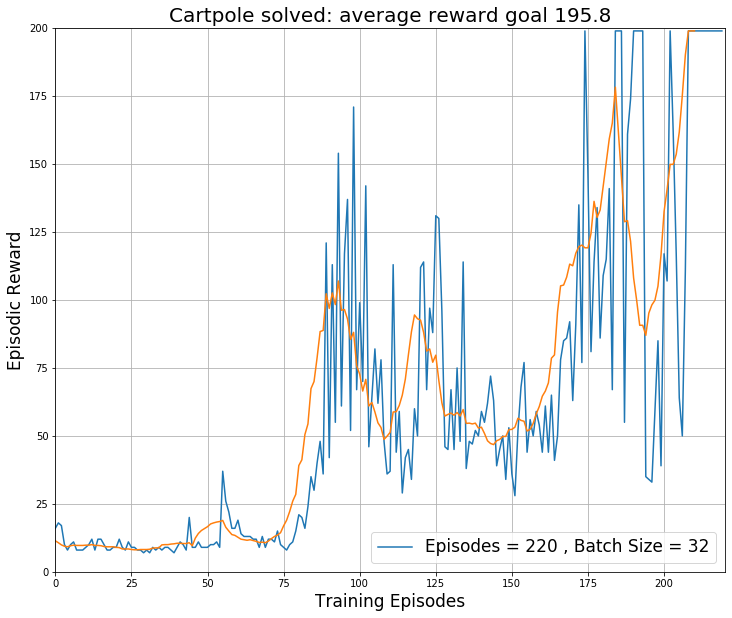

In [0]:
plt.figure()
plt.figure(figsize=[12, 10])
plt.title('Cartpole solved: average reward goal 195.8',fontsize=20)
plt.xlabel('Training Episodes',fontsize=17)
plt.ylabel('Episodic Reward',fontsize=17)
plt.xlim((0,220))
plt.ylim((0,200))
plt.grid(True)
epi_time = epi_time[:220]
plt.plot(epi_time)
plt.plot(np.convolve(epi_time,np.ones(10)/10, mode='valid'))

plt.legend(['Episodes = 220 , Batch Size = 32'], loc='lower right', fontsize=17)
plt.savefig('./Cartpole.PNG', dpi=400)
plt.show()